series.shape:(1113,)


C:\Users\xyt556\PycharmProjects\big_data\envi\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


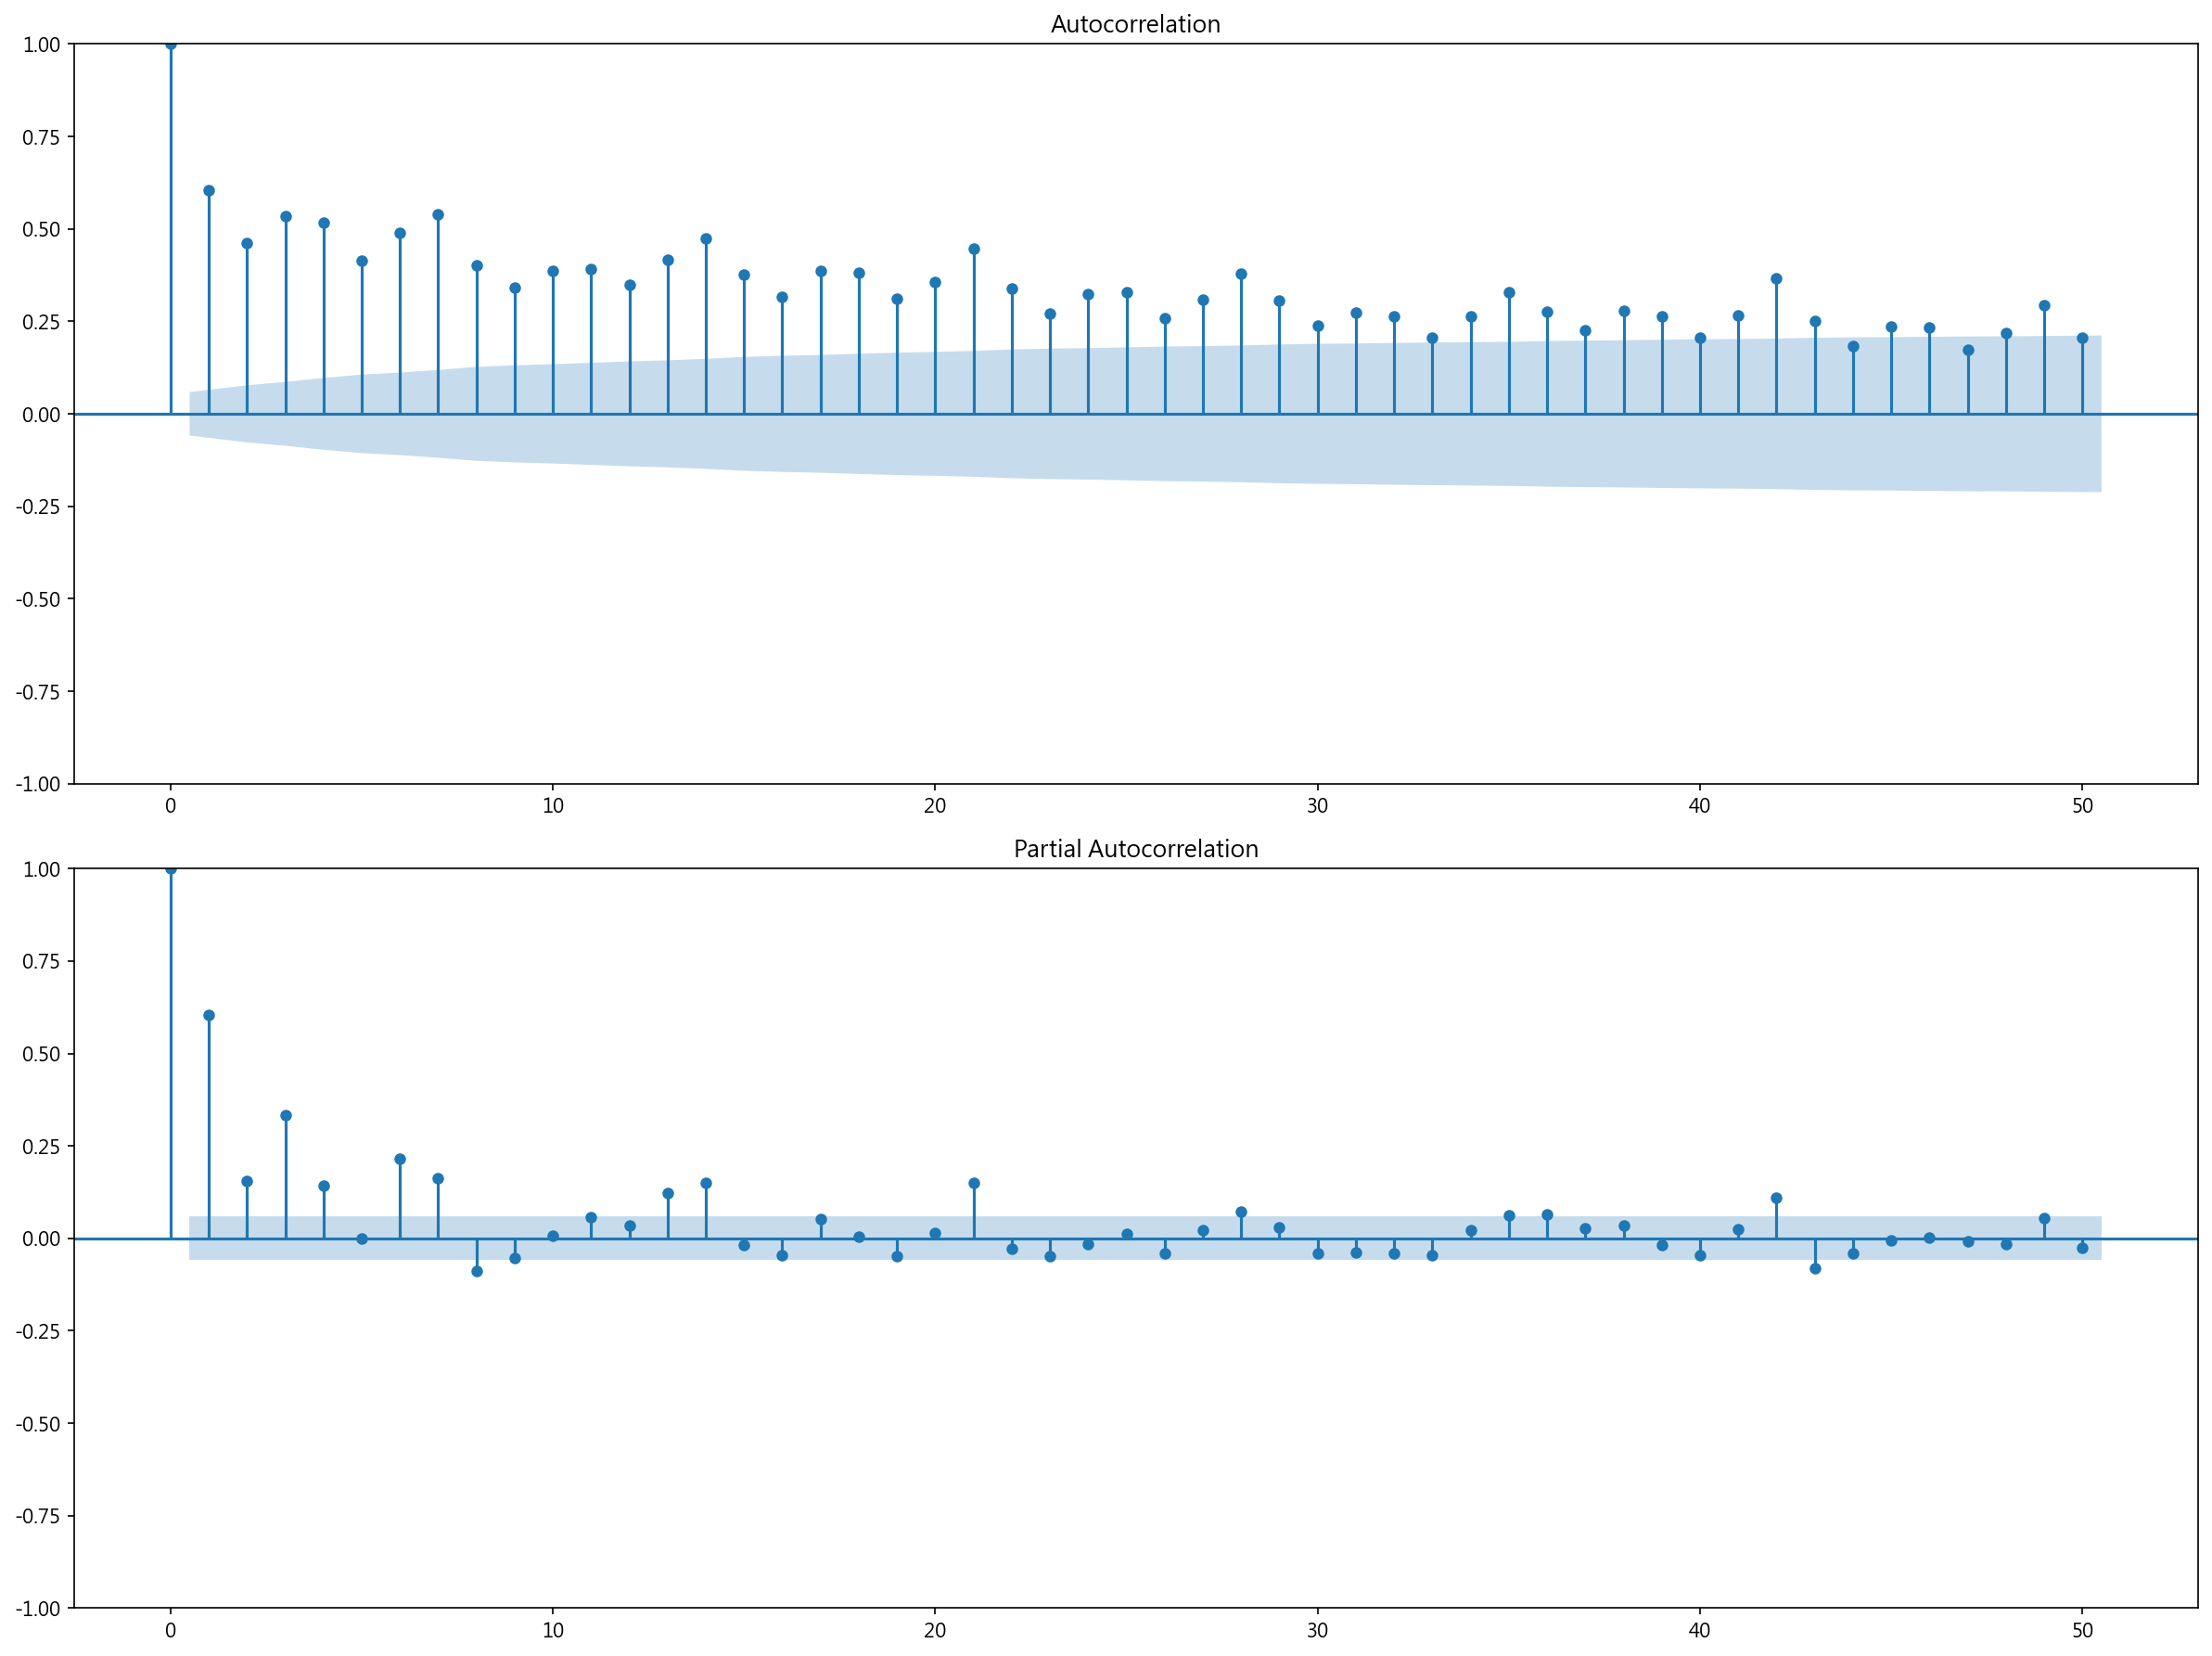

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False


def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def to_series(data):
    '''
    该函数将多变量序列转化成单变量序列
    '''
    series = [week[:, 0] for week in data]
    series = np.array(series).flatten()
    print('series.shape:{}'.format(series.shape))
    return series

def plot_acf_pacf(series, lags):
    '''
    该函数实现绘制acf图和pacf图
    '''
    plt.figure(figsize=(16,12), dpi=150)
    axis = plt.subplot(2, 1, 1)
    sm.graphics.tsa.plot_acf(series, ax=axis, lags=lags)
    
    axis = plt.subplot(2, 1, 2)
    sm.graphics.tsa.plot_pacf(series, ax=axis, lags=lags)
    
    
    plt.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, engine='c',
                   parse_dates=['datetime'], index_col=['datetime'])

    lags = 50#365
    train, test = split_dataset(dataset.values)
    series = to_series(train)
    plot_acf_pacf(series, lags)
    

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn.metrics as skm
import statsmodels.tsa as smt
from statsmodels.tsa.arima_model import ARIMA
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

def split_dataset(data):
    '''
    该函数实现以周为单位切分训练数据和测试数据
    '''
    # data为按天的耗电量统计数据，shape为(1442, 8)
    # 测试集取最后一年的46周（322天）数据，剩下的159周（1113天）数据为训练集，以下的切片实现此功能。
    train, test = data[1:-328], data[-328:-6]
    train = np.array(np.split(train, len(train)/7)) # 将数据划分为按周为单位的数据
    test = np.array(np.split(test, len(test)/7))
    return train, test

def evaluate_forecasts(actual, predicted):
    '''
    该函数实现根据预期值评估一个或多个周预测损失
    思路：统计所有单日预测的 RMSE
    '''
    scores = list()
    for i in range(actual.shape[1]):
        mse = skm.mean_squared_error(actual[:, i], predicted[:, i])
        rmse = math.sqrt(mse)
        scores.append(rmse)
    
    s = 0 # 计算总的 RMSE
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    print('actual.shape[0]:{}, actual.shape[1]:{}'.format(actual.shape[0], actual.shape[1]))
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s\n' % (name, score, s_scores))

def evaluate_model(model_func, train, test):
    '''
    该函数实现评估单个模型
    '''
    history = [x for x in train] # # 以周为单位的数据列表
    predictions = [] # 每周的前项预测值
    for i in range(len(test)):
        yhat_sequence = model_func(history) # 预测每周的耗电量
        predictions.append(yhat_sequence)
        history.append(test[i, :]) # 将测试数据中的采样值添加到history列表，以便预测下周的用电量
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions) # 评估一周中每天的预测损失
    return score, scores

def to_series(data):
    '''
    该函数将多变量序列转化成单变量序列
    '''
    series = [week[:, 0] for week in data]
    series = np.array(series).flatten()
    print('series.shape:{}'.format(series.shape))
    return series


def arima_forecast(history):
    '''
    该函数定义ARIMA模型并进行训练和预测
    '''
    series = to_series(history)

    model = ARIMA(series, order=(7,0,0))
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

def model_predict_plot(dataset, days):
    train, test = split_dataset(dataset.values)
    #定义要评估的模型的名称和函数
    models = dict()
    models['arima'] = arima_forecast
    
    plt.figure(figsize=(8,6), dpi=150)
    for name, func in models.items():
        score, scores = evaluate_model(func, train, test)
        summarize_scores(name, score, scores)
        plt.plot(days, scores, marker='o', label=name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.ylabel(r'$RMSE$', size=15)
    plt.title('ARIMA 模型预测结果',  size=18)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    dataset = pd.read_csv('household_power_consumption_days.csv', header=0, 
                       infer_datetime_format=True, engine='c',
                       parse_dates=['datetime'], index_col=['datetime'])
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
    model_predict_plot(dataset, days)

series.shape:(1113,)


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


<Figure size 1200x900 with 0 Axes>